In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing

#### Training set has 48 columns, while test set has 24 columns. The last 24 training columns are missing in the test data set!
- The first column (fecha_dato) is the date column. The second column (ncodpers) is the customer_id. 
- The third column (ind_empleado) is the status of employment; The fourth column (pais_residencia) is country of residency
- The fifth column (sexo) is sex; The six column (age); The seventh column (fecha_alta) is the date of join
- The eightth column (ind_nuevo) is new costumer; The ninth column (antiguedad) is antiquity (古老,古代)
- 

/home/ubuntu/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
ncodpers                 200000 non-null int64
age                      198063 non-null float64
ind_nuevo                198063 non-null float64
antiguedad               198063 non-null float64
indrel                   198063 non-null float64
indrel_1mes              198063 non-null float64
conyuemp                 0 non-null float64
tipodom                  198063 non-null float64
cod_prov                 197660 non-null float64
ind_actividad_cliente    198063 non-null float64
renta                    162995 non-null float64
dtypes: float64(10), int64(1)
memory usage: 16.8 MB
None


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


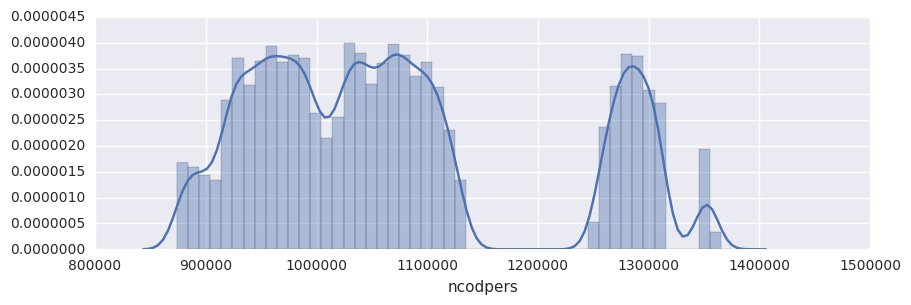

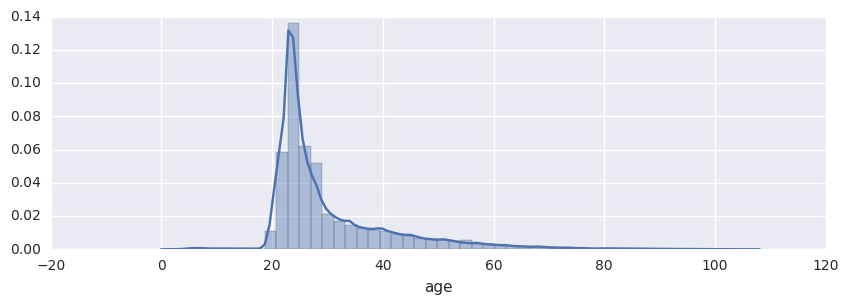

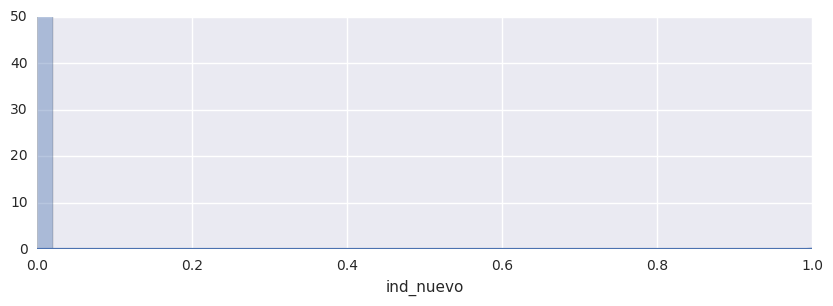

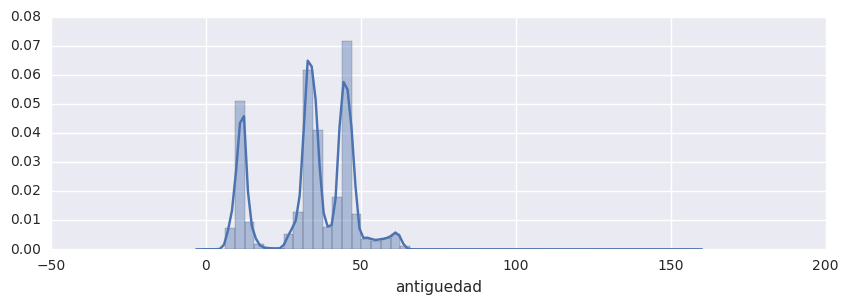

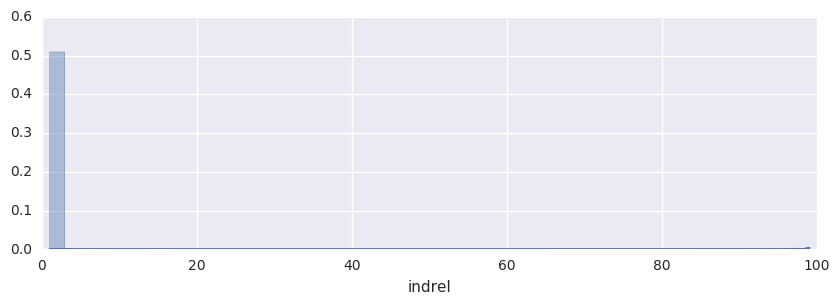

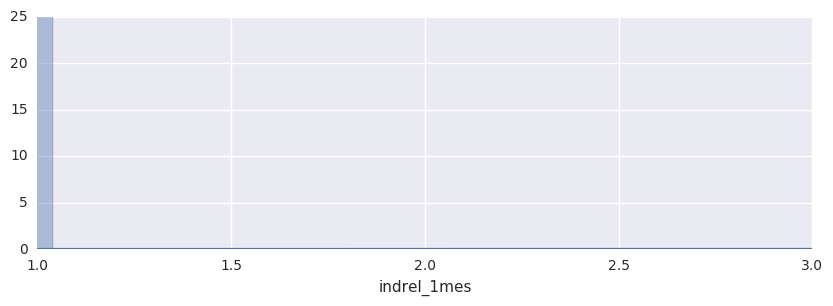

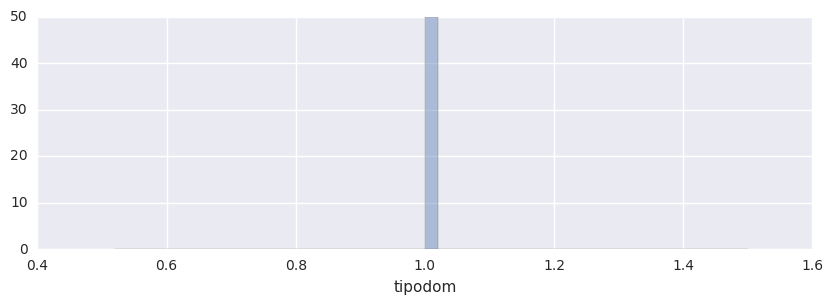

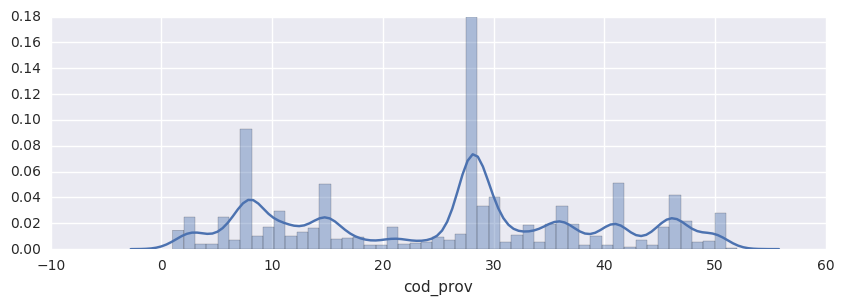

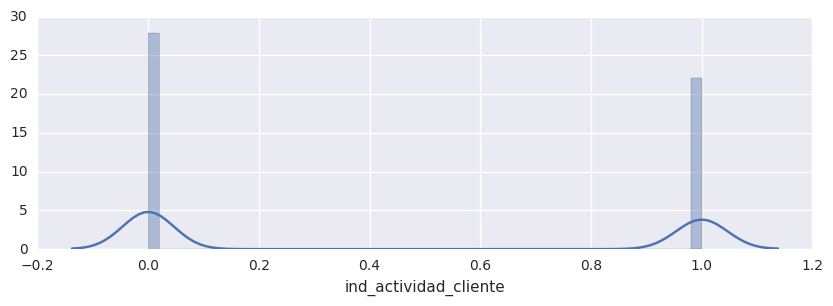

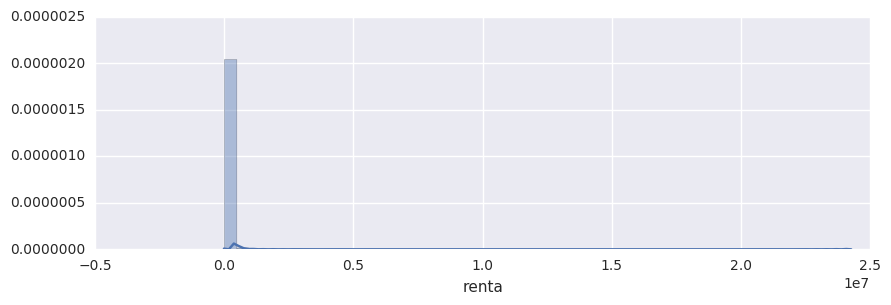

In [2]:
# read in data first
train = pd.read_csv("../../data/train_ver2.csv", nrows=200000)
test = pd.read_csv('../../data/test_ver2.csv', nrows=200000)
#print(train.info())
#print(test.info())
#print(train.tail())

# here age is an object, we need to convert it to numeric
train['age'] = pd.to_numeric(train['age'], errors='coerce')
test['age'] = pd.to_numeric(test['age'], errors='coerce')

# antiguedad is also an object, we need to convert it to numeric
train['antiguedad'] = pd.to_numeric(train['antiguedad'], errors='coerce')
test['antiguedad'] = pd.to_numeric(test['antiguedad'], errors='coerce')

# sepatate last 24 columns from training dataset
trainX = train.iloc[:,:24]

# separate numeric columns from object (categorical) columns
dat_num = trainX.select_dtypes(exclude=['object'])
dat_cat = trainX.select_dtypes(include=['object'])
print(dat_num.info())
#print(dat_cat.info())

# the conyuemp column is empty at 100000, so remove it
dat_num.drop('conyuemp', 1, inplace=True)

from collections import Counter
for col in dat_num.columns.values:
    if col == 'conyuemp':
        print(Counter(dat_num[col].dropna()))

# check data distributions
col_names = dat_num.columns

for i in range(10):
    #fig, axes = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(8,3))
    fig = plt.figure(figsize=(10,3))
    sns.distplot(dat_num[col_names[i]].dropna(), bins=50)
    plt.show()


### Handle Missing Data

In [3]:
# check to see if any of the columns has missing values and how many for each column
# if there are missing values, we might need to impute/fill-in those missing values
no_nan_cols = []
for col, val in train.isnull().any().items():
    if val == True:
        #print("number of nan for column ", col, " is: ", train[col].isnull().sum())
        pass
    else:
        #no_nan_cols.append(col)
        pass
print("these columns has no nan values in them", no_nan_cols)

these columns has no nan values in them []


#### for ind_nuevo, need to find out more info

In [4]:
# find out how many nan for ind_neuvo
print("The total nan in ind_nuevo is ", dat_num['ind_nuevo'].isnull().sum())
# for ind_nuevo: from graph, it is binary. let's find out using Count()
print(Counter(dat_num['ind_nuevo'].dropna()))

The total nan in ind_nuevo is  1937
Counter({0.0: 198018, 1.0: 45})


#### From distribution graph, ind_nuevo is binary. >95% of values are 0.0, so we will try to find out their history

In [5]:
history = dat_num.loc[dat_num['ind_nuevo'].isnull(),:].groupby("ncodpers", sort=False).size()
print(max(history))

1


In [6]:
#### they all new customers. So set the value to 1
dat_num['ind_nuevo'].fillna(1.0, inplace=True)
# dat_num.loc[dat_num['ind_neuvo'].isnull(), 'ind_neuvo'] = 1.0
print(dat_num['ind_nuevo'].isnull().any())

False


/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### for antiguedad (antiquity)

In [7]:
print("how many contains nan for antiquity: ", dat_num['antiguedad'].isnull().sum())

# find out the most common one
print(Counter(dat_num['antiguedad'].dropna()))

# it seems the number of nan in antiguedad is the same as ind_nuevo
# Probably the same people that we just determined were new customers. Double check
dat_num.loc[dat_num['antiguedad'].isnull(), 'ind_nuevo'].describe()

# yes, same people as they all nan. Let's give them minimum seniority. or 25% percentile
print(dat_num['antiguedad'].dropna().describe())

# the 25 percentile is 14
dat_num['antiguedad'].fillna(14.0, inplace=True)
print("check if any nan left in antiguedad: ", dat_num['antiguedad'].isnull().any())


how many contains nan for antiquity:  1937
Counter({12.0: 18621, 33.0: 15695, 45.0: 14451, 36.0: 12082, 44.0: 11911, 35.0: 11816, 34.0: 11720, 32.0: 10926, 46.0: 10168, 43.0: 8537, 47.0: 8024, 10.0: 7564, 48.0: 6124, 11.0: 5585, 8.0: 4461, 31.0: 4250, 13.0: 2430, 30.0: 2205, 14.0: 2140, 38.0: 1805, 27.0: 1705, 40.0: 1569, 37.0: 1548, 29.0: 1521, 39.0: 1444, 62.0: 1418, 41.0: 1410, 42.0: 1282, 15.0: 1277, 28.0: 1272, 61.0: 1260, 52.0: 901, 59.0: 886, 16.0: 829, 49.0: 816, 63.0: 793, 58.0: 763, 53.0: 761, 57.0: 716, 60.0: 707, 50.0: 689, 54.0: 682, 51.0: 626, 55.0: 596, 56.0: 592, 26.0: 387, 18.0: 346, 9.0: 139, 21.0: 107, 6.0: 71, 7.0: 69, 22.0: 58, 20.0: 55, 23.0: 52, 24.0: 47, 17.0: 37, 19.0: 36, 25.0: 36, 0.0: 10, 1.0: 9, 3.0: 9, 4.0: 6, 2.0: 5, 5.0: 5, 157.0: 1})
count    198063.000000
mean         33.746530
std          13.703911
min           0.000000
25%          30.000000
50%          35.000000
75%          45.000000
max         157.000000
Name: antiguedad, dtype: float64
check 

/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### now for 'indrel' column, which indicates
- 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [8]:
# find out how many rows are nan
print(dat_num['indrel'].isnull().sum())

# find out the most common count information
print(Counter(dat_num['indrel'].dropna()))

# fill in with most common one here
dat_num['indrel'].fillna(1.0, inplace=True)

print("Checking to see if the column has no more nan: ", dat_num['indrel'].isnull().any())

1937
Counter({1.0: 197738, 99.0: 325})
Checking to see if the column has no more nan:  False


/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### now for 'indrel_1mes' column

In [9]:
# find out how many rows contain nan
print(dat_num['indrel_1mes'].isnull().sum())

# find out the most common count info
print(Counter(dat_num['indrel_1mes'].dropna()))

# fill in with the most common one here
dat_num['indrel_1mes'].fillna(1.0, inplace=True)
print("Check to see if there is any nan left: ", dat_num['indrel_1mes'].isnull().any())

1937
Counter({1.0: 198057, 3.0: 6})
Check to see if there is any nan left:  False


/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### for tipodom: (Addres type. 1, primary address)
- tipodom doesn't seem to be useful, so I am going to drop it, as it doesn't provide any useful information!

In [10]:
# find out how many in there
print(dat_num['tipodom'].isnull().sum())

# find out the most commone one
print(Counter(dat_num['tipodom'].dropna()))

# drop it
#dat_num['tipodom'].fillna(1.0, inplace=True)
#print("Check to see if there is still any nan left: ", dat_num['tipodom'].isnull().any())

1937
Counter({1.0: 198063})


#### for cod_prov: provincial code for the address
- it seems that nom_prov is the name of the provincial. So they are redundant. We only need one of them.
- the nom_prov will be removed!!!

In [11]:
# find out how many are nan
print("number of nan is ", dat_num['cod_prov'].isnull().sum())

# find out how many 'nom_prov' is nan
print("number of nan for nom_prov is: ", dat_cat['nomprov'].isnull().sum())

# to see if they are the same entries
train.loc[train['cod_prov'].isnull(), 'nomprov'].describe()
prov = train[['cod_prov', 'nomprov']]
#print(prov[prov['cod_prov'].isnull()])

# find out the unique values in cod_prov
print(dat_num['cod_prov'].unique())

# set the nan to 0 
dat_num['cod_prov'].fillna(0, inplace=True)
print(dat_num['cod_prov'].unique())

number of nan is  2340
number of nan for nom_prov is:  2340
[ 29.  13.  50.  45.  24.  20.  10.  17.  49.   8.  37.   9.  22.  31.   5.
  40.  27.  25.  28.   3.  42.  41.  39.   7.  47.  36.  46.  44.  15.  32.
  23.  16.  48.  12.  26.   2.   6.  30.  11.  nan   4.  19.  34.  35.  14.
  21.  18.  33.  38.  52.  43.   1.  51.]
[ 29.  13.  50.  45.  24.  20.  10.  17.  49.   8.  37.   9.  22.  31.   5.
  40.  27.  25.  28.   3.  42.  41.  39.   7.  47.  36.  46.  44.  15.  32.
  23.  16.  48.  12.  26.   2.   6.  30.  11.   0.   4.  19.  34.  35.  14.
  21.  18.  33.  38.  52.  43.   1.  51.]


/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### ind_actividad_cliente  (Ind_activity customer)
- from the data distribution, it is binary

In [12]:
print("Total number of nan is: ", dat_num['ind_actividad_cliente'].isnull().sum())

print("Find out the most common ones: ", Counter(dat_num['ind_actividad_cliente'].dropna()))

# need more time and reading, but right now, I will use the median
#print("Median value is: ", dat_num['ind_actividad_cliente'].dropna().mean())

dat_num['ind_actividad_cliente'].fillna(0.5, inplace=True)

print("Find out the most common ones: ", Counter(dat_num['ind_actividad_cliente'].dropna()))


Total number of nan is:  1937
Find out the most common ones:  Counter({0.0: 110431, 1.0: 87632})
Find out the most common ones:  Counter({0.0: 110431, 1.0: 87632, 0.5: 1937})


/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### renta (rental)
- Here is a feature that is missing a lot of values. Rather than just filling them in with a median, it's probably more accurate to break it down region by region. To that end, let's take a look at the median income by region, and in the spirit of the competition let's color it like the Spanish flag.

In [ ]:
print("Number of nan: ", dat_num['renta'].isnull().sum())

# from distribution, they are mostly close to the lower end
print("The count info: ", dat_num['renta'].dropna().describe())

# group them by provincial code and find out the median of each one
#ave_rental = dat_num['renta'].dropna().groupby(dat_num['cod_prov']).describe()
ave_rental = dat_num['renta'].dropna().groupby(dat_num['cod_prov'].astype(int)).mean()
ave_rental = dict(ave_rental)
print(ave_rental)

index = dat_num[dat_num['renta'].isnull()].index.tolist()
#print(index)

for idx in index:
    prov_code = dat_num.ix[idx, 'cod_prov'].astype(int)
    if prov_code in ave_rental.keys():
        dat_num.ix[idx, 'renta'] = ave_rental[prov_code]

print("Number of nan: ", dat_num['renta'].isnull().sum())


Number of nan:  36954
The count info:  count    1.630460e+05
mean     1.163119e+05
std      1.648509e+05
min      1.000000e+02
25%      6.222192e+04
50%      8.970479e+04
75%      1.334945e+05
max      2.425324e+07
Name: renta, dtype: float64
{2: 81518.397938634618, 3: 82047.763443642762, 4: 87672.25313043475, 5: 79156.725829787261, 6: 68737.412751219454, 7: 160109.6988409094, 8: 161142.20030922769, 9: 96389.34196551732, 10: 74013.427313746433, 11: 95320.837266000075, 12: 77085.52253465337, 13: 66436.631876075728, 14: 80989.202901554367, 15: 107977.2665434899, 16: 68785.450877193027, 17: 142998.84535483873, 18: 89125.009048239735, 19: 94943.650255102024, 20: 80599.139999999999, 21: 75690.530415956149, 22: 82294.037226753673, 23: 74690.61435960597, 24: 88388.671923474627, 25: 80147.747012811786, 26: 95912.235599022009, 27: 77012.309199218769, 28: 171712.3250134805, 29: 110425.08029110535, 30: 78039.324350833485, 31: 73737.764999999999, 32: 81475.785494095602, 33: 97894.940159680758, 34:

/home/ubuntu/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
